<a href="https://colab.research.google.com/github/raguram/eva/blob/master/S11/CIFAR10_Assignment11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount the drive and load required modules

In [1]:
from os.path import join
import sys
from google.colab import drive

# Mount the drive
ROOT = "/content/drive"
drive.mount(ROOT, force_remount=True)

LIBRARY_ROOT = "/content/drive/My Drive/Colab Notebooks/workspace/eva/cnn-lib/src"
sys.path.append(LIBRARY_ROOT)
sys.path.append(LIBRARY_ROOT + "/cnnlib")

Mounted at /content/drive


In [2]:
!pip install albumentations==0.4.5


In [3]:
from torchvision import datasets, transforms
from cnnlib.ModelBuilder import ModelTester
import torch
import Utility 
import DataUtility
import MetricsUtility
import ModelBuilder
from Functions import LossFn
import torch.nn.functional as F
import torch.optim as optim
from ModelBuilder import ModelBuilder
import models.Resnet as Resnet
import torch.nn as nn
from albumentations import *
from albumentations.pytorch import ToTensor
import numpy as np
from DataUtility import Alb
import cv2
from lr_finder import LRFinder
from torch.optim.lr_scheduler import OneCycleLR
from models.S11Resnet import S11Resnet

  pip install torch-lr-finder -v --global-option="amp"


### Load the data and perform required transformations

Files already downloaded and verified
Files already downloaded and verified
Shape of a train data batch: torch.Size([512, 3, 32, 32])
Shape of a test data batch: torch.Size([512, 3, 32, 32])
Number of train images: 50000
Number of test images: 10000


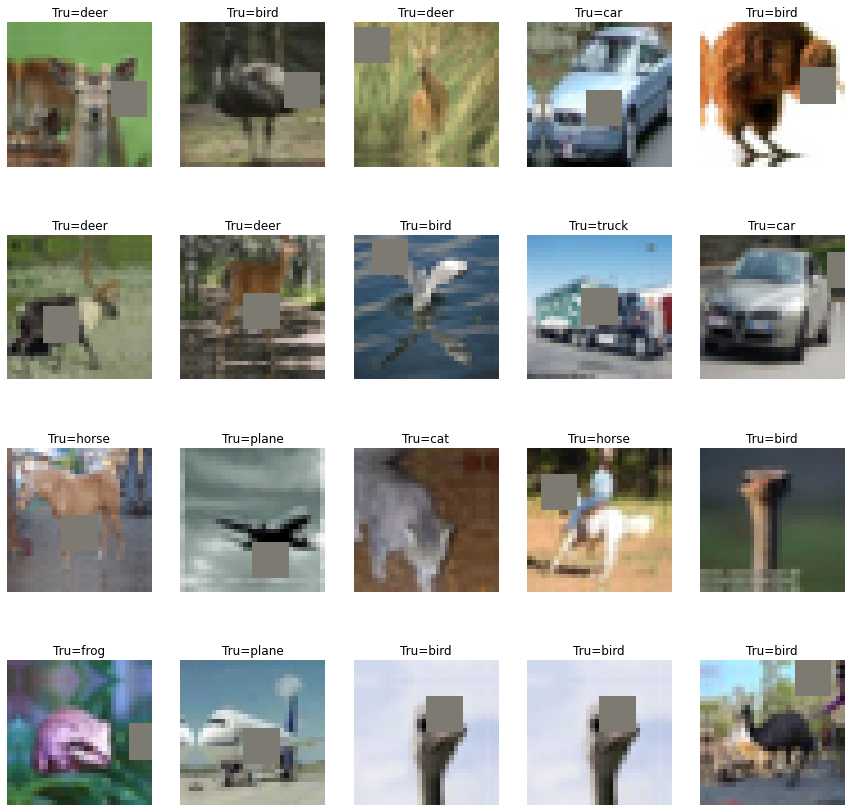

In [4]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

mean_array = np.array([*mean])


train_transforms = Compose([
                            PadIfNeeded(40, 40, always_apply=True, p=1.0),
                            RandomCrop(32, 32, always_apply=True, p=1.0),
                            HorizontalFlip(p=0.5),
                            Cutout(num_holes=1, max_h_size=8, max_w_size=8, fill_value=np.array([*mean])*255.0, p=0.75),
                            Normalize(mean, std),
                            ToTensor()
])
  
test_transforms = Compose([
          Normalize(mean, std),
          ToTensor()
          ])

data=DataUtility.download_CIFAR10(Alb(train_transforms), Alb(test_transforms), batch_size=512)
DataUtility.showLoaderImages(data.train, count=20, classes=data.classes, muSigmaPair=(mean, std))

## Initialize the network and view the summary

In [5]:
from torchsummary import summary
summary(S11Resnet().to(Utility.getDevice()), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
        InputLayer-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
  ConvMaxPoolBlock-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,456
      BatchNorm2d-14          [-1, 128,

/content/drive/My Drive/Colab Notebooks/workspace/eva/cnn-lib/src/cnnlib/models/S11Resnet.py:95: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [0]:
net = S11Resnet().to(Utility.getDevice())
criterion = LossFn(F.nll_loss, model=net, l2Factor=0.01)

## LR Finder

/content/drive/My Drive/Colab Notebooks/workspace/eva/cnn-lib/src/cnnlib/models/S11Resnet.py:95: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Learning rate search finished. See the graph with {finder_name}.plot()


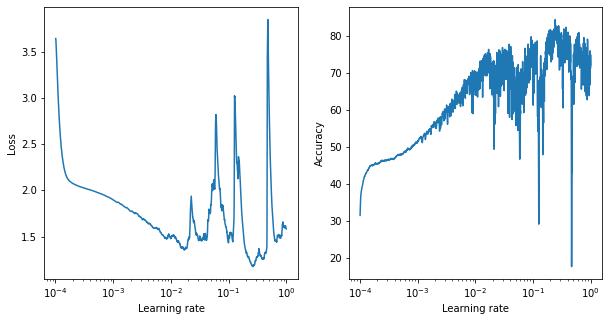

In [13]:
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
finder = LRFinder(net, optimizer, criterion, device="cuda")

finder.range_test(data.train, val_loader=data.test, start_lr=0.0001, end_lr=1,
                     num_iter=20 * len(data.train), step_mode="exp")
finder.plot()
finder.reset()


In [14]:
bestLR = finder.history["lr"][finder.history["loss"].index(finder.best_loss)]
print(f"Best LR: {bestLR}")
finder.reset()

Best LR: 0.2645141928287876


## Train the network

In [15]:
epochs = 24
optimizer = optim.SGD(net.parameters(), lr = bestLR, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=bestLR, epochs=epochs, steps_per_epoch=len(data.train), 
                       pct_start=5/epochs, anneal_strategy='linear', div_factor=25.0, final_div_factor=1)
builder = ModelBuilder(net, data, criterion, optimizer, scheduler)
result = builder.fit(epochs)



Epoch: 1


/content/drive/My Drive/Colab Notebooks/workspace/eva/cnn-lib/src/cnnlib/models/S11Resnet.py:95: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Train Accuracy: 40.394%, Train Loss: 0.004842899739742279, Learning Rate: 0.010580567713151502



Test Accuracy: 37.0%, Test Loss: 0.007202346809208393


Epoch: 2



Train Accuracy: 49.704%, Train Loss: 0.004379160702228546, Learning Rate: 0.061471151069659336



Test Accuracy: 44.64%, Test Loss: 0.006779879797250032


Epoch: 3



Train Accuracy: 62.04%, Train Loss: 0.0034557892940938473, Learning Rate: 0.11236173442616718



Test Accuracy: 65.67%, Test Loss: 0.003098136279731989


Epoch: 4



Train Accuracy: 70.624%, Train Loss: 0.0028146090917289257, Learning Rate: 0.16325231778267502



Test Accuracy: 67.96%, Test Loss: 0.0031902617774903774


Epoch: 5



Train Accuracy: 74.854%, Train Loss: 0.0025633403565734625, Learning Rate: 0.21414290113918283



Test Accuracy: 79.73%, Test Loss: 0.0022902293130755424


Epoch: 6



Train Accuracy: 79.298%, Train Loss: 0.0022661094553768635, Learning Rate: 0.26437781601615834



Test Accuracy: 78.77%, Test Loss: 0.002332911593839526


Epoch: 7



Train Accuracy: 82.32%, Train Loss: 0.002066846704110503, Learning Rate: 0.2510128883784933



Test Accuracy: 80.56%, Test Loss: 0.0022618593648076057


Epoch: 8



Train Accuracy: 83.706%, Train Loss: 0.0019773361273109913, Learning Rate: 0.23764796074082822



Test Accuracy: 82.09%, Test Loss: 0.002134055830538273


Epoch: 9



Train Accuracy: 85.884%, Train Loss: 0.0018506047781556845, Learning Rate: 0.22428303310316317



Test Accuracy: 82.87%, Test Loss: 0.0021044588647782803


Epoch: 10



Train Accuracy: 86.878%, Train Loss: 0.001791443326510489, Learning Rate: 0.2109181054654981



Test Accuracy: 87.5%, Test Loss: 0.0018226118991151452


Epoch: 11



Train Accuracy: 88.138%, Train Loss: 0.0017185924807563424, Learning Rate: 0.19755317782783305



Test Accuracy: 80.59%, Test Loss: 0.0022395236883312464


Epoch: 12



Train Accuracy: 89.018%, Train Loss: 0.0016534331953153014, Learning Rate: 0.184188250190168



Test Accuracy: 85.86%, Test Loss: 0.0019021424232050776


Epoch: 13



Train Accuracy: 89.752%, Train Loss: 0.001607780228368938, Learning Rate: 0.17082332255250293



Test Accuracy: 85.53%, Test Loss: 0.001954645849764347


Epoch: 14



Train Accuracy: 90.118%, Train Loss: 0.001582292141392827, Learning Rate: 0.15745839491483787



Test Accuracy: 87.23%, Test Loss: 0.0018091569654643536


Epoch: 15



Train Accuracy: 91.218%, Train Loss: 0.0015200675697997212, Learning Rate: 0.14409346727717284



Test Accuracy: 87.76%, Test Loss: 0.001812522066757083


Epoch: 16



Train Accuracy: 91.856%, Train Loss: 0.00148224167060107, Learning Rate: 0.13072853963950778



Test Accuracy: 87.73%, Test Loss: 0.001806904561817646


Epoch: 17



Train Accuracy: 92.564%, Train Loss: 0.0014260770985856652, Learning Rate: 0.11736361200184275



Test Accuracy: 88.52%, Test Loss: 0.001792239141650498


Epoch: 18



Train Accuracy: 93.17%, Train Loss: 0.0013939334312453866, Learning Rate: 0.10399868436417767



Test Accuracy: 89.59%, Test Loss: 0.0017101304838433862


Epoch: 19



Train Accuracy: 94.048%, Train Loss: 0.0013455908047035336, Learning Rate: 0.09063375672651261



Test Accuracy: 89.46%, Test Loss: 0.001698488020338118


Epoch: 20



Train Accuracy: 94.282%, Train Loss: 0.0013193920021876693, Learning Rate: 0.07726882908884758



Test Accuracy: 89.91%, Test Loss: 0.0016702467110008001


Epoch: 21



Train Accuracy: 95.288%, Train Loss: 0.0012621930800378323, Learning Rate: 0.0639039014511825



Test Accuracy: 89.55%, Test Loss: 0.001721360138617456


Epoch: 22



Train Accuracy: 95.976%, Train Loss: 0.001218399265781045, Learning Rate: 0.05053897381351746



Test Accuracy: 91.13%, Test Loss: 0.0016124192625284195


Epoch: 23



Train Accuracy: 96.626%, Train Loss: 0.0011708836536854506, Learning Rate: 0.03717404617585238



Test Accuracy: 91.48%, Test Loss: 0.0016008622478693724


Epoch: 24



Train Accuracy: 97.28%, Train Loss: 0.0011341755744069815, Learning Rate: 0.023809118538187346



Test Accuracy: 92.13%, Test Loss: 0.0015624120132997632


## Plot metrics and loss

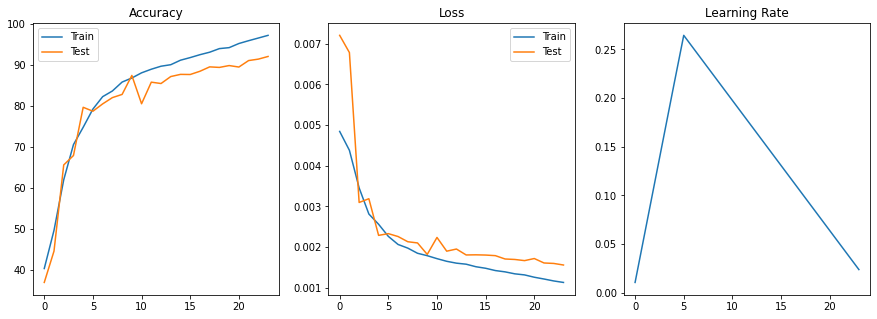

In [16]:
MetricsUtility.plotMetrics(result)

## View miss classified images

/content/drive/My Drive/Colab Notebooks/workspace/eva/cnn-lib/src/cnnlib/models/S11Resnet.py:95: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



[[926   5  15   7   4   0   3   3  29   8]
 [  4 978   0   0   0   0   1   0   3  14]
 [ 17   0 893  15  24  10  25  11   2   3]
 [  5   2  27 822  24  78  23   8   5   6]
 [  2   1  18  14 924   9  13  16   2   1]
 [  3   0  14  63  24 870   4  21   0   1]
 [  3   2   9  23   6   2 954   1   0   0]
 [  6   0   6   4  14  12   2 951   2   3]
 [ 23   7   2   2   0   1   2   0 957   6]
 [  7  34   2   2   1   1   1   2  12 938]]


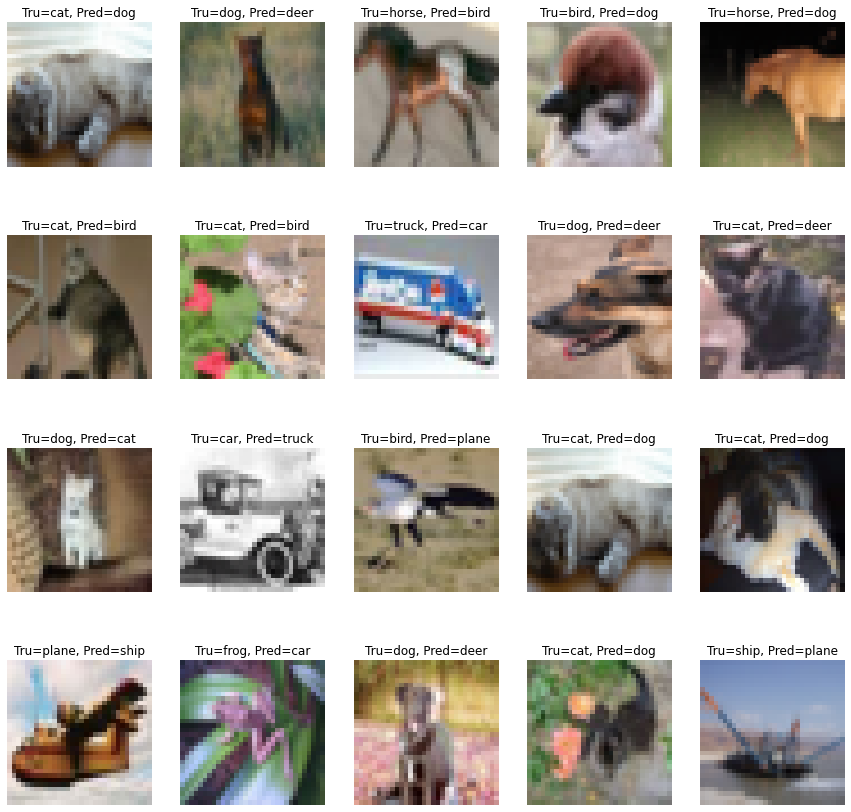

In [17]:
cpu = torch.device("cpu")
testResult = ModelTester().test(net, data.test, criterion)
metrics = MetricsUtility.computeMetrics(testResult.data, testResult.predictions, testResult.targets)
DataUtility.showRandomImages(metrics.miss_classified_data.to(cpu), metrics.miss_classified_targets.to(cpu), metrics.miss_classified_predictions.to(cpu), data.classes, muSigmaPair=(mean, std))

## Visualize GradCam

/content/drive/My Drive/Colab Notebooks/workspace/eva/cnn-lib/src/cnnlib/models/S11Resnet.py:95: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


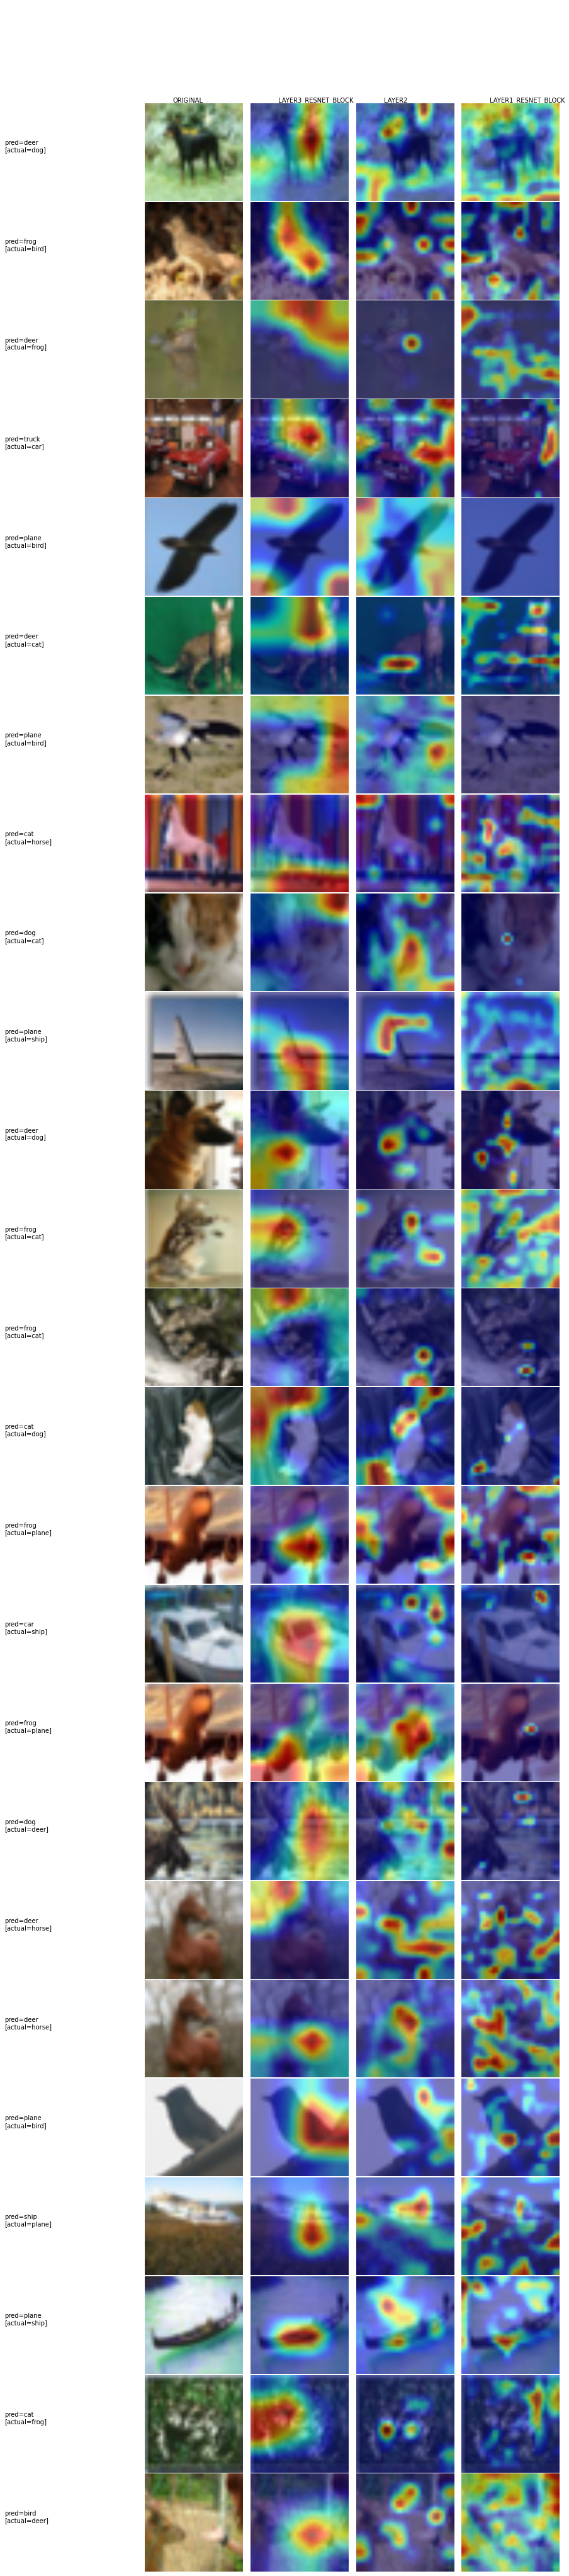

In [18]:
from GradCam import GradCam, Analyzer

cpuNet = net.to(cpu)
layers = ["layer3_resnet_block", "layer2", "layer1_resnet_block"]
analyzer = Analyzer(GradCam(cpuNet, layers))

analyzer.visualize(metrics.miss_classified_data.to(cpu), metrics.miss_classified_targets.to(cpu), data.classes, muSigPair=(mean, std), figSize=(15, 75), count=25)